### Задание

В лекции мы выяснили, что при проведении АА-теста было бы здорово убедиться в том, что наша система сплитования работает корректно, и ключевая метрика не отличается между группами не только в конкретно нашем АА-тесте, но и в целом.

В идеале было бы здорово провести бесконечное количество АA-тестов и посмотреть, в каком количестве случаем нам удалось отклонить нулевую гипотезу. Если система сплитования работает корректно, то статистически значимые различия между двумя группами встречались бы только в результате случайного ложного срабатывания. Например, если мы отвергаем нулевую гипотезу при условии, что p_value < 0.05, то только приблизительно в 5% случаев у нас бы получались статистические значимые различия между 0 и 1 группой.

Понятное дело, что на практике провести бесконечное число тестов у нас навряд ли получится, поэтому используется небольшой трюк! Мы будем многократно извлекать подвыборки из наших данных, проводить t-test, и в конце посмотрим, в каком проценте случаев нам удалось отклонить нулевую гипотезу.

Итак, что нужно сделать: у нас есть данные АА-теста с '2022-09-26' по '2022-10-02'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.



In [1]:
 # импорт библиотек
import pandas as pd
import numpy as np
import pandahouse
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from tqdm.auto import tqdm

# кастомизация графиков
custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False, 
                 'figure.figsize': (10, 4)}
sns.set_theme(style = "ticks", rc = custom_params)

In [2]:
 connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [3]:
 # достанем данные из БД
query = """  
select 
    user_id, exp_group,
    countIf(action, action = 'like') as likes,
    countIf(action, action = 'view') as views,
    likes / views as ctr
from simulator_20221020.feed_actions
where toDate(time) between '2022-09-26' and '2022-10-02' 
                                and exp_group in (2, 3)
group by user_id, exp_group
order by user_id
"""

df = pandahouse.read_clickhouse(query, connection = connection)

In [4]:
df.head(3)

,user_id,exp_group,likes,views,ctr
0,200,3,12,36,0.333333
1,204,3,8,38,0.210526
2,207,3,22,61,0.360656


In [5]:
 df.shape

(17049, 5)

In [6]:
# посмотрим на распределение пользователей внутри групп
df.groupby('exp_group', as_index = False).agg({'user_id': 'count'})

,exp_group,user_id
0,2,8480
1,3,8569


<AxesSubplot:xlabel='ctr', ylabel='Count'>

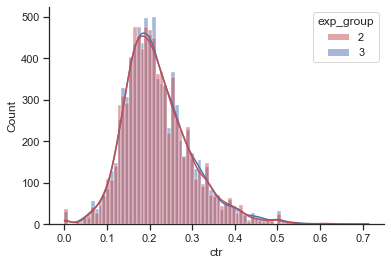

In [7]:
# визуализируем распределение ctr'ов внутри групп
sns.histplot(data = df, x = 'ctr', hue = 'exp_group', 
             palette = ['r', 'b'], alpha = 0.5, kde = True, bins = 80)

In [8]:
# напишем функцию для а/а тестирования
def a_a_testing(group_a, group_b, iterations = 10000):
    
    ''' 
    Функция принимает на вход две выборки, проводит множество синтетических т-тестов и возвращает массив со значениями p-values этих тестов,
    а также распечатывает гистограмму распределения p-values и сообщает, работает ли система сплитования корректно.
    '''
    
    # сюда будем складывать p-values
    p_values = np.array([])
    
    # в цикле проведем множество синтетических а/а тестов
    for i in tqdm(range(iterations)):
        p_value = st.ttest_ind(group_a.sample(500, replace = False),
                               group_b.sample(500, replace = False),
                               equal_var = False)[1]

        p_values = np.append(p_values, p_value)
        
    # визуализируем распределение p-values
    sns.histplot(p_values, alpha=0.75, kde=False)
    plt.title('p-values')
    plt.show
    
    # метрика качества системы сплитования
    fpr_05 = (p_values < 0.05).sum() / len(p_values)
    fpr_01 = (p_values < 0.01).sum() / len(p_values)
    fpr_005 = (p_values < 0.005).sum() / len(p_values)
    
    # вердикт
    if fpr_05 > 0.05:
        print(f'''Split system is broken:
              FPR is {fpr_05} with 0.05 significnce level
              FPR is {fpr_01} with 0.01 significnce level
              FPR is {fpr_055} with 0.005 significnce level''')
        print('------------------------------------------------------')
        print('')
    else:
        print(f'''Split system works well: 
              FPR is {fpr_05} with 0.05 significnce level
              FPR is {fpr_01} with 0.01 significnce level
              FPR is {fpr_005} with 0.005 significnce level''')
        print('------------------------------------------------------')
        print('')
    
    return(p_values)

In [9]:
# достанем значения из групп
group_1 = df.query('exp_group == 2').ctr
group_2 = df.query('exp_group == 3').ctr

  0%|          | 0/10000 [00:00<?, ?it/s]

Split system works well: 
              FPR is 0.0456 with 0.05 significnce level
              FPR is 0.0087 with 0.01 significnce level
              FPR is 0.0041 with 0.005 significnce level
------------------------------------------------------



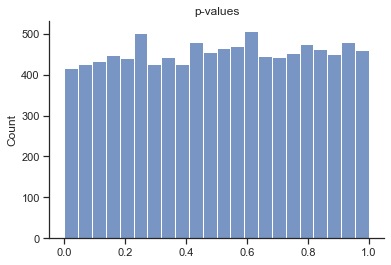

In [10]:
# посимулируем
result = a_a_testing(group_1, group_2, iterations = 10000)

### Вывод

Система сплитования работает корректно: распределение p-values равномерное, FPR <= alpha на уровне статистической значимости 0.05.